In [31]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from IPython.display import Audio
import tensorflow as tf
import sklearn as sk
import joblib
import gc
import seaborn

%matplotlib inline

In [2]:
y, sr = librosa.load("../Datasets/11.mp3")
print(f"Shape: {y.shape}")
print(f"Sample Rate: {sr}")
print(f"chroma FPS: {len(y) / sr}")

Shape: (269535,)
Sample Rate: 22050
chroma FPS: 12.223809523809523


In [3]:
Audio(y, rate=sr)

# Default (STFT)

In [4]:
S = np.abs(librosa.stft(y))
hop_length = int(sr * 0.1) # per 100 ms
chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
print(chroma.shape)

(12, 123)


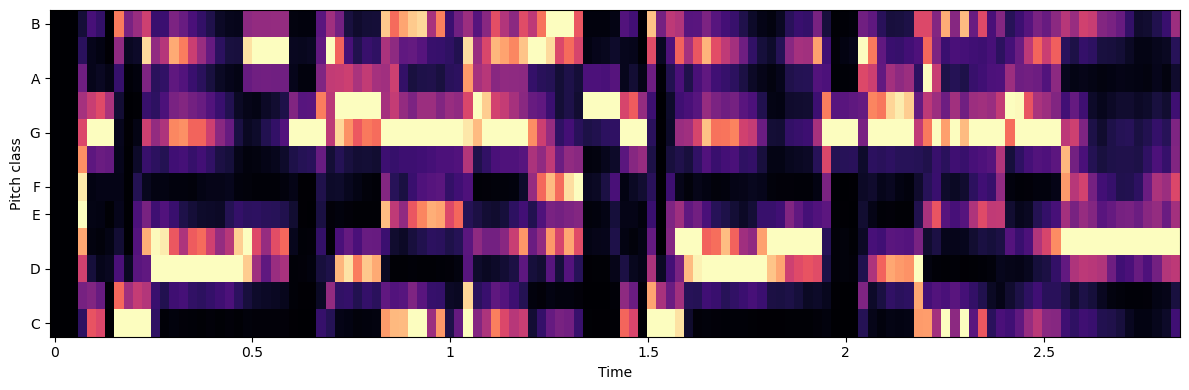

In [5]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(chroma, y_axis="chroma", x_axis="time")
plt.tight_layout()

# Enhanced (Q-Constant)
https://librosa.org/doc/main/auto_examples/plot_chroma.html#enhanced-chroma

## 1. Harmonics

In [6]:
y_harm = librosa.effects.harmonic(y=y, margin=10)
chroma_harm = librosa.feature.chroma_cqt(y=y_harm, sr=sr, hop_length=hop_length)
# chroma_harm = librosa.feature.chroma_stft(y=y_harm, sr=sr, hop_length=hop_length)

In [7]:
Audio(data=y_harm, rate=sr)

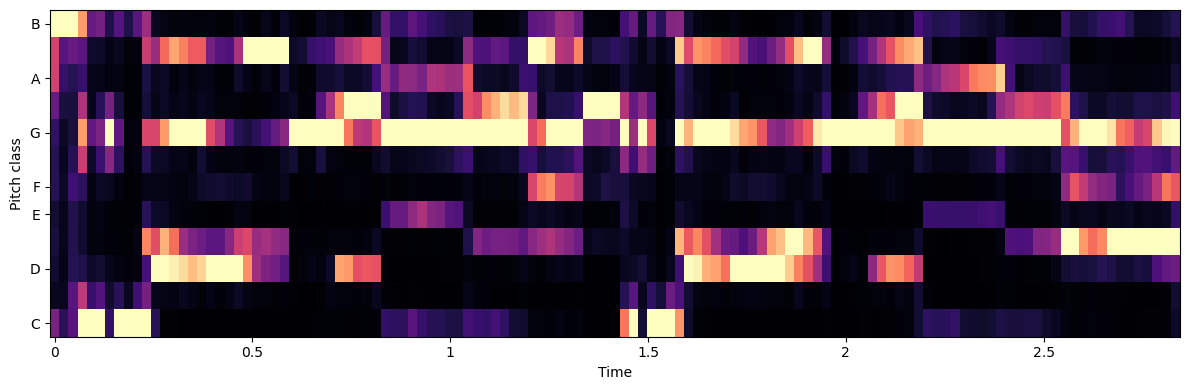

In [8]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(chroma_harm, y_axis="chroma", x_axis="time")
plt.tight_layout()

## 2. Non local filtering

In [9]:
chroma_filter = np.minimum(
    chroma_harm,
    librosa.decompose.nn_filter(chroma_harm, aggregate=np.median)
)

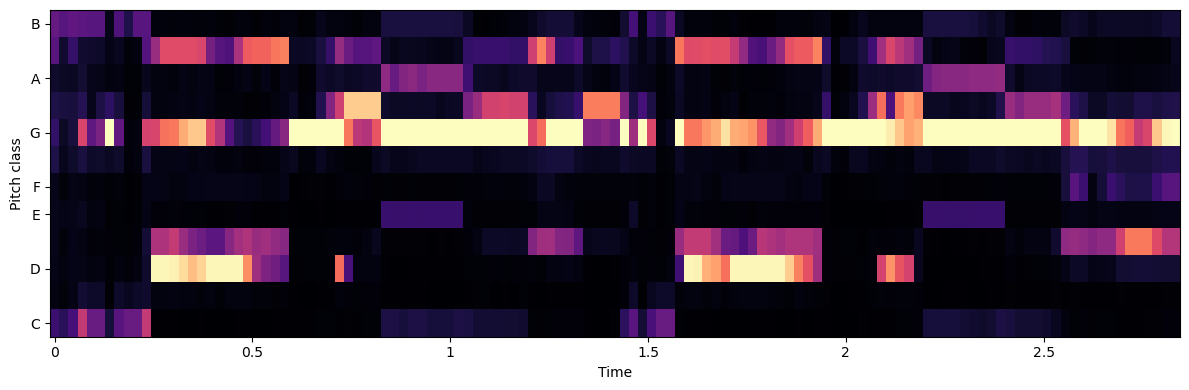

In [10]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(chroma_filter, y_axis="chroma", x_axis="time")
plt.tight_layout()

## 3. Smoothing

In [11]:
chroma_smooth = scipy.ndimage.median_filter(chroma_filter, size=(1, 9))

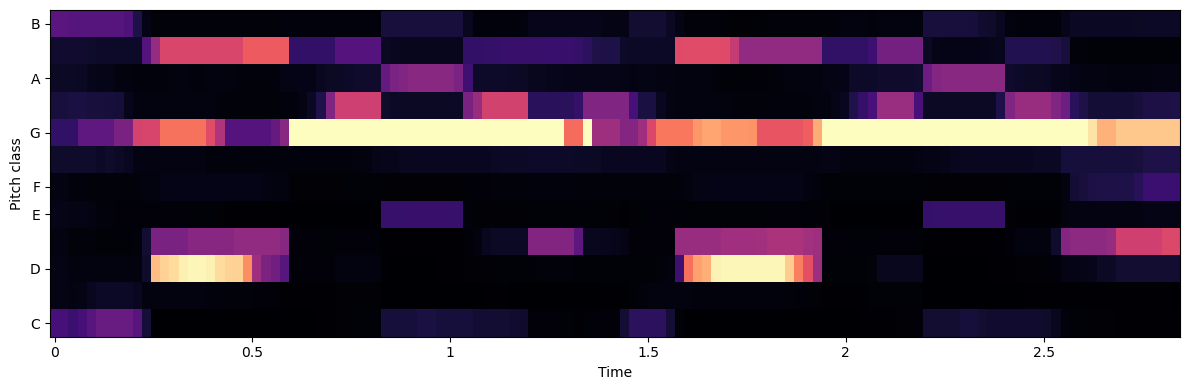

In [12]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(chroma_smooth, y_axis="chroma", x_axis="time")
plt.tight_layout()

# Chroma CENS

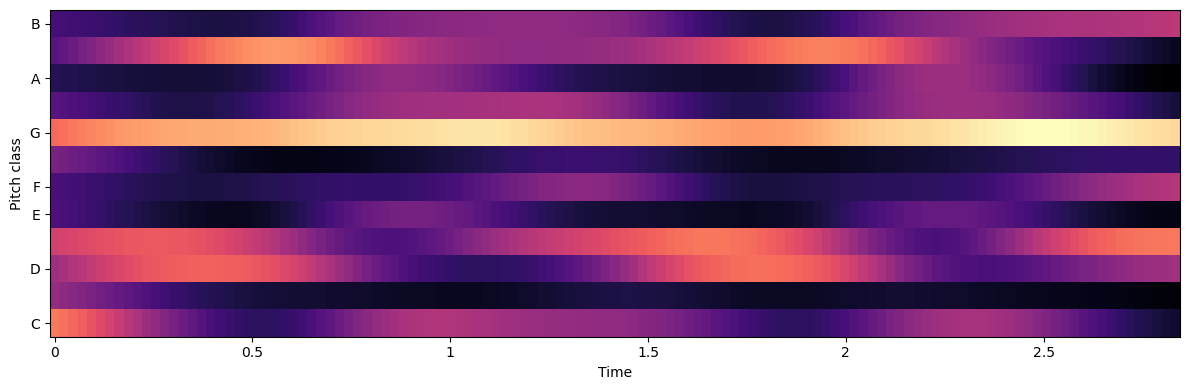

In [13]:
chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr, hop_length=hop_length, )
plt.figure(figsize=(12, 4))
librosa.display.specshow(chroma_cens, y_axis="chroma", x_axis="time")
plt.tight_layout()

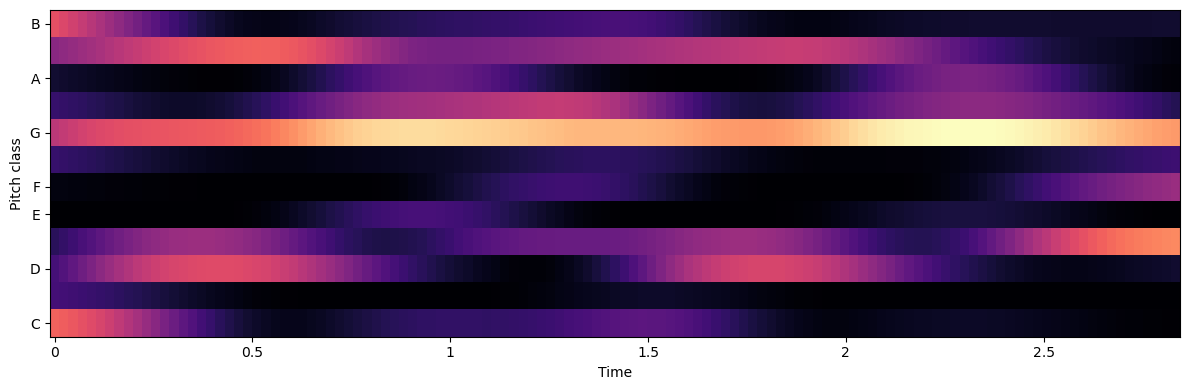

In [14]:
chroma_cens_harm = librosa.feature.chroma_cens(y=y_harm, sr=sr, hop_length=hop_length)
plt.figure(figsize=(12, 4))
librosa.display.specshow(chroma_cens_harm, y_axis="chroma", x_axis="time")
plt.tight_layout()

# Dataset

In [17]:
df = pd.read_hdf("./dataset.h5", key="df")
encoder = joblib.load("./encoder.xz")
y = df["chord"]
X = df.drop(columns="chord")
y_encoded = encoder.fit_transform(y)

SEQUENCE_LEN = 20 # 0.1 * 20.0 = 2 sec of sequence data

X_seq, y_encoded_seq = None, None
X_seq_list = []
y_encoded_seq_list = []
for i in range(len(X) - SEQUENCE_LEN + 1):
    X_seq_list.append(X.values[i : i + SEQUENCE_LEN, :])
    y_encoded_seq_list.append(y_encoded[i + SEQUENCE_LEN - 1])

X_seq, y_encoded_seq = np.array(X_seq_list), np.array(y_encoded_seq_list)

X_seq_flat = X_seq.reshape(X_seq.shape[0], -1)
_, unique_idx = np.unique(X_seq_flat, axis=0, return_index=True)
unique_idx = np.sort(unique_idx)

X_seq = X_seq[unique_idx]
y_encoded_seq = y_encoded_seq[unique_idx]

X_seq_train, X_seq_test, y_seq_train, y_seq_test = sk.model_selection.train_test_split(
    X_seq,
    y_encoded_seq,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded_seq,
)

del df
del X_seq_list
del y_encoded_seq_list
del X_seq_flat
del X_seq
del y_encoded_seq

gc.collect()

27100

# Model

In [23]:
model = tf.keras.models.load_model("./model_lstm_cens_64_64.keras")
history = pd.read_csv("./History/model_lstm_cens_64_64_history.csv")
y_pred = np.argmax(model.predict(X_seq_test), axis=1)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step


## Learning Curve

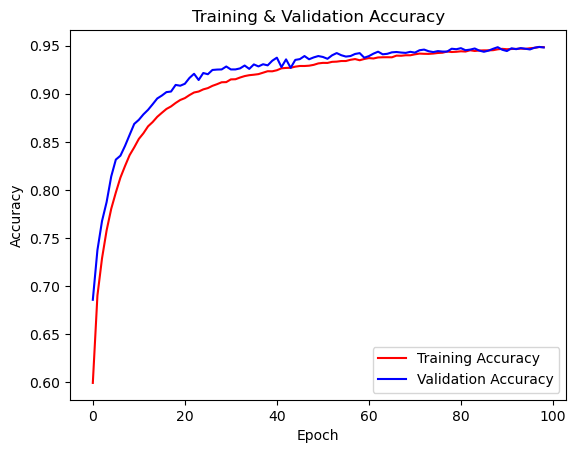

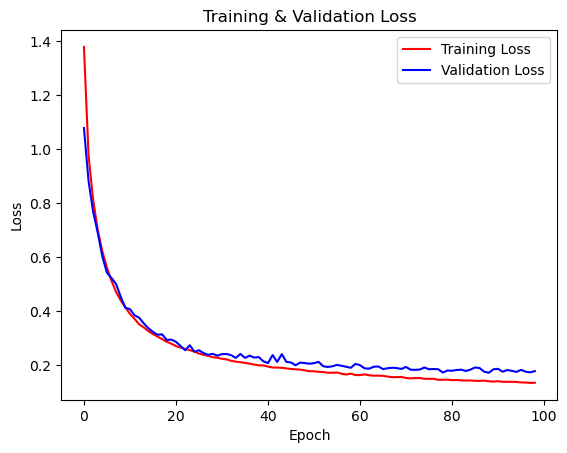

In [21]:
epoch = range(len(history["accuracy"]))

plt.plot(epoch, history["accuracy"], "r", label="Training Accuracy")
plt.plot(epoch, history["val_accuracy"], "b", label="Validation Accuracy")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(epoch, history["loss"], "r", label="Training Loss")
plt.plot(epoch, history["val_loss"], "b", label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Confusion Matrix

In [38]:
cm = sk.metrics.confusion_matrix(y_seq_test, y_pred)
cm_df = pd.DataFrame(cm, index=encoder.classes_, columns=encoder.classes_)
cm_df.to_csv("normalized_confusion_matrix.csv")
cm_df

,A7,AMaj7,AMin7,Ab7,AbMaj7,AbMin7,B7,BMaj7,BMin7,Bb7,...,EbMin7,F7,FMaj7,FMin7,G7,GMaj7,GMin7,Gb7,GbMaj7,GbMin7
A7,608,2,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
AMaj7,1,2914,7,5,3,4,0,6,12,3,...,0,7,0,0,1,10,1,3,0,20
AMin7,2,4,2842,1,4,6,8,1,3,8,...,0,0,12,8,2,6,5,0,0,1
Ab7,0,1,0,618,1,1,0,0,0,0,...,1,0,0,0,2,0,1,0,0,2
AbMaj7,3,0,0,3,2837,4,0,0,0,2,...,0,1,0,29,12,0,5,0,16,0
AbMin7,12,7,5,1,1,2962,0,10,1,10,...,7,0,0,4,2,7,6,7,19,19
B7,0,3,4,0,0,2,625,0,0,0,...,0,0,0,0,0,1,0,0,1,2
BMaj7,0,18,0,0,0,21,0,2741,8,9,...,14,0,0,0,1,0,2,4,21,3
BMin7,8,12,13,0,0,3,0,1,2794,2,...,5,1,0,0,1,9,1,12,3,15
Bb7,0,2,1,0,1,2,0,0,0,648,...,0,0,0,3,0,0,0,0,0,0
